In [12]:
#!/usr/bin/env python
import os
import argparse
from plantcv import plantcv as pcv
import cv2
import numpy as np

In [13]:
img = cv2.imread("testing.png")

In [14]:
# Convert RGB to HSV and extract the saturation channel
# Inputs:
#   rgb_image - RGB image data 
#   channel - Split by 'h' (hue), 's' (saturation), or 'v' (value) channel

s = pcv.rgb2gray_hsv(rgb_img=img, channel='s')
cv2.imwrite("gray_hsv.png",s)

True

In [15]:
# Threshold the saturation image

# Inputs:
#   gray_img - Grayscale image data 
#   threshold- Threshold value (between 0-255)
#   max_value - Value to apply above threshold (255 = white) 
#   object_type - 'light' (default) or 'dark'. If the object is lighter than the 
#                 background then standard threshold is done. If the object is 
#                 darker than the background then inverse thresholding is done. 

s_thresh = pcv.threshold.binary(gray_img=s, threshold=85, max_value=255, object_type='light')
cv2.imwrite("threshold.binary.jpg",s_thresh)

True

In [16]:
# Median Blur
# Inputs: 
#   gray_img - Grayscale image data 
#   ksize - Kernel size (integer or tuple), (ksize, ksize) box if integer input,
#           (n, m) box if tuple input 

s_mblur = pcv.median_blur(gray_img=s_thresh, ksize=5)
s_cnt = pcv.median_blur(gray_img=s_thresh, ksize=5)
cv2.imwrite("s_cnt.jpg",s_cnt)

True

In [17]:
# Convert RGB to LAB and extract the Blue channel

# Input:
#   rgb_img - RGB image data 
#   channel- Split by 'l' (lightness), 'a' (green-magenta), or 'b' (blue-yellow) channel
b = pcv.rgb2gray_lab(rgb_img=img, channel='b')

# Threshold the blue image
b_thresh = pcv.threshold.binary(gray_img=b, threshold=160, max_value=255, 
                                    object_type='light')
b_cnt = pcv.threshold.binary(gray_img=b, threshold=160, max_value=255, 
                                 object_type='light')
cv2.imwrite("b_thresh.jpg",b_thresh)
cv2.imwrite("b_cnt.jpg",b_cnt)

True

In [18]:
# Join the thresholded saturation and blue-yellow images

# Inputs: 
#   bin_img1 - Binary image data to be compared to bin_img2
#   bin_img2 - Binary image data to be compared to bin_img1

bs = pcv.logical_or(bin_img1=s_mblur, bin_img2=b_cnt)

cv2.imwrite("bs.jpg",bs)

True

In [19]:
# Apply Mask (for VIS images, mask_color=white)

# Inputs:
#   rgb_img - RGB image data 
#   mask - Binary mask image data 
#   mask_color - 'white' or 'black' 

masked = pcv.apply_mask(img, mask=bs, mask_color='white')

cv2.imwrite("masked.jpg",masked)

True

In [20]:
# Convert RGB to LAB and extract the Green-Magenta and Blue-Yellow channels
masked_a = pcv.rgb2gray_lab(rgb_img=masked, channel='a')
cv2.imwrite("masked_a.jpg",masked_a)


masked_b = pcv.rgb2gray_lab(rgb_img=masked, channel='b')
cv2.imwrite("masked_B.jpg",masked_b)

# Threshold the green-magenta and blue images
maskeda_thresh = pcv.threshold.binary(gray_img=masked_a, threshold=115, 
                                      max_value=255, object_type='dark')
cv2.imwrite("masked_thresh.jpg",maskeda_thresh)

maskeda_thresh1 = pcv.threshold.binary(gray_img=masked_a, threshold=135, 
                                           max_value=255, object_type='light')
cv2.imwrite("masked_thresh1.jpg",maskeda_thresh1)

maskedb_thresh = pcv.threshold.binary(gray_img=masked_b, threshold=128, 
                                          max_value=255, object_type='light')
cv2.imwrite("maskedb_thresh.jpg",maskedb_thresh)

# Join the thresholded saturation and blue-yellow images (OR)
ab1 = pcv.logical_or(bin_img1=maskeda_thresh, bin_img2=maskedb_thresh)
cv2.imwrite("ab1.jpg",ab1)

ab = pcv.logical_or(bin_img1=maskeda_thresh1, bin_img2=ab1)
cv2.imwrite("ab.jpg",ab1)

# Fill small objects
# Inputs: 
#   bin_img - Binary image data 
#   size - Minimum object area size in pixels (must be an integer), and smaller objects will be filled
ab_fill = pcv.fill(bin_img=ab, size=200)
cv2.imwrite("ab_fill.jpg",ab_fill)

# Apply mask (for VIS images, mask_color=white)
masked2 = pcv.apply_mask(masked, mask=ab_fill, mask_color='white')
cv2.imwrite("masked2.jpg",masked2)


True

In [21]:
id_objects, obj_hierarchy = pcv.find_objects(masked2, ab_fill)
#print(id_objects)
#cv2.imwrite("idobj",np.int32(id_objects))

# Define ROI
# Inputs: 
#   img - RGB or grayscale image to plot the ROI on 
#   x - The x-coordinate of the upper left corner of the rectangle 
#   y - The y-coordinate of the upper left corner of the rectangle 
#   h - The height of the rectangle
#   w - The width of the rectangle 
roi1, roi_hierarchy= pcv.roi.rectangle(img=masked2, x=100, y=100, h=200, w=200)

# Decide which objects to keep
# Inputs:
#    img            = img to display kept objects
#    roi_contour    = contour of roi, output from any ROI function
#    roi_hierarchy  = contour of roi, output from any ROI function
#    object_contour = contours of objects, output from pcv.find_objects function
#    obj_hierarchy  = hierarchy of objects, output from pcv.find_objects function
#    roi_type       = 'partial' (default, for partially inside), 'cutto', or 
#    'largest' (keep only largest contour)
roi_objects, hierarchy3, kept_mask, obj_area = pcv.roi_objects(img=img, roi_contour=roi1, 
                                                                   roi_hierarchy=roi_hierarchy, 
                                                                   object_contour=id_objects, 
                                                                   obj_hierarchy=obj_hierarchy,
                                                                   roi_type='partial')

# Object combine kept objects
# Inputs:
#   img - RGB or grayscale image data for plotting 
#   contours - Contour list 
#   hierarchy - Contour hierarchy array 
obj, mask = pcv.object_composition(img=img, contours=roi_objects, hierarchy=hierarchy3)


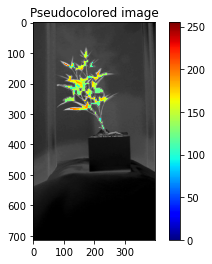

In [22]:
    # Inputs:
    #   img - RGB or grayscale image data 
    #   obj- Single or grouped contour object
    #   mask - Binary image mask to use as mask for moments analysis     
shape_img = pcv.analyze_object(img=img, obj=obj, mask=mask)
cv2.imwrite("shape_img.jpg",shape_img)

    # Shape properties relative to user boundary line (optional)

    # Inputs:
    #   img - RGB or grayscale image data 
    #   obj - Single or grouped contour object 
    #   mask - Binary mask of selected contours 
    #   line_position - Position of boundary line (a value of 0 would draw a line 
    #                   through the bottom of the image) 
boundary_img1 = pcv.analyze_bound_horizontal(img=img, obj=obj, mask=mask, 
                                                   line_position=1680)
cv2.imwrite("boundary_img1.jpg",boundary_img1)
    # Determine color properties: Histograms, Color Slices, output color analyzed histogram (optional)

    # Inputs:
    #   rgb_img - RGB image data
    #   mask - Binary mask of selected contours 
    #   hist_plot_type - None (default), 'all', 'rgb', 'lab', or 'hsv'
    #                    This is the data to be printed to the SVG histogram file  
color_histogram = pcv.analyze_color(rgb_img=img, mask=kept_mask, hist_plot_type='all')
    # Pseudocolor the grayscale image

    # Inputs:
    #     gray_img - Grayscale image data
    #     obj - Single or grouped contour object (optional), if provided the pseudocolored image gets 
    #           cropped down to the region of interest.
    #     mask - Binary mask (optional) 
    #     background - Background color/type. Options are "image" (gray_img, default), "white", or "black". A mask 
    #                  must be supplied.
    #     cmap - Colormap
    #     min_value - Minimum value for range of interest
    #     max_value - Maximum value for range of interest
    #     dpi - Dots per inch for image if printed out (optional, if dpi=None then the default is set to 100 dpi).
    #     axes - If False then the title, x-axis, and y-axis won't be displayed (default axes=True).
    #     colorbar - If False then the colorbar won't be displayed (default colorbar=True)
pseudocolored_img = pcv.visualize.pseudocolor(gray_img=s, mask=kept_mask, cmap='jet')
